# Tutorial for UED

This notebook is a tutorial for:
 - generating 3D structure of cereals;
 - plotting 3D scenes of cereal mixtures;
 - computing light interception on 3D scenes.

## 0. Imports

In [1]:
import numpy as np
from oawidgets.plantgl import *
from openalea.plantgl.all import Material, Color3, Scene
import oawidgets.mtg

from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.display import build_scene, display_scene
import matplotlib.pyplot as plt
%gui qt

## 1. Set management parameters

Set parameters regarding the spatial (and temporal) configuration of the crop.

In [2]:
sowing_density = 10
inter_row = 0.4

## 2. Format crop-scale growth and senescence dynamics

From crop-scale data either measured or simulated with a crop model, generate a dictionnary of dictionnaries for each day with the following values :
 - "Thermal time" (float): cumulated thermal time from beginning of simulation to current day (in °C.day)
 - "Phenology" (str): current phenological stage (germination, juvenile, exponential or repro)
 - "Plant leaf area" (float): plant leaf area (in cm²) 
 - "Leaf area increment" (float): leaf area increment compared to previous day (in cm²) 
 - "Plant senescent leaf area" (float): senescent plant leaf area (in cm²) 
 - "Senescent leaf area increment" (float): senescent leaf area increment compared to previous day (in cm²) 
 - "Plant height" (float): plant height (in cm) 
 - "Height increment" (float): height increment compared to previous day (in cm).

In [3]:
# Input Time series at crop scale
# for the example, one value every 18 days
thermal_time = np.cumsum([tt*18 for tt in [3, 10, 11, 13, 18, 14, 13, 15, 13, 10]]) # cumulated thermal time
lai = [0.01, 0.77, 2.46, 5.00, 5.81, 5.81, 5.81, 5.81, 5.81, 5.81] # crop-scale
height = [0.00004, 0.02, 1.04, 2.05, 2.42, 2.46, 2.46, 2.46, 2.46, 2.46]
sen_lai = [0.00, 0.00, 0.00, 0.20, 0.60, 1.00, 2.00, 3.00, 4.00, 5.81] # crop-scale

In [ ]:
# If static simulation of plant:
# thermal_time = [0.0]
# lai = [5.81]
# height = [2.46]
# sen_lai = [0.0]

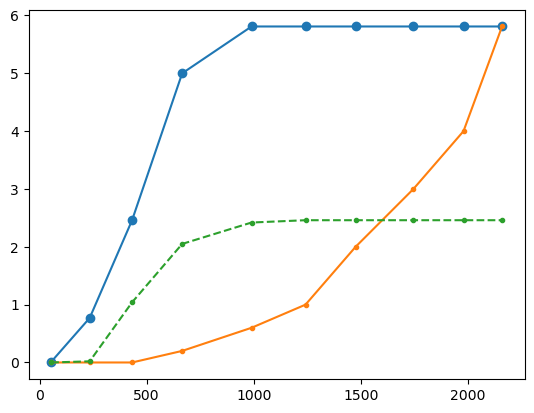

In [4]:
plt.plot(thermal_time, lai,'o-')
plt.plot(thermal_time, sen_lai,'.-')
plt.plot(thermal_time, height, '.--')

In [5]:
# conversion m -> cm
cm = 100
leaf_area_plant = [la / sowing_density * cm**2  for la in lai] # for 1 plant
sen_leaf_area_plant = [sen_la / sowing_density * cm**2 for sen_la in sen_lai] # for 1 plant
height_canopy = [h * cm for h in height] # height of the canopy
# Phenology parameters, in days
emergence = 0 # start of the simulation for a sole crop
end_juv = 3 
max_lai = 6

# Fill dict of dicts for daily dynamics
daily_dynamics = {
        i+1: {"Thermal time": thermal_time[i],
              "Phenology": 'germination' if i+1 < emergence else 'juvenile' if emergence <= i+1 < end_juv else 'exponential' if end_juv <= i+1 < max_lai else 'repro',
              "Plant leaf area": leaf_area_plant[i], 
              "Leaf area increment": leaf_area_plant[i] - leaf_area_plant[i-1] if i > 0 else leaf_area_plant[i], 
              "Plant senescent leaf area": sen_leaf_area_plant[i],
              "Senescent leaf area increment": sen_leaf_area_plant[i] - sen_leaf_area_plant[i-1] if i > 0 else sen_leaf_area_plant[i],
              "Plant height": height_canopy[i], 
              "Height increment": height_canopy[i] - height_canopy[i-1] if i > 0 else height_canopy[i]
             }
        for i in range(len(thermal_time))
}

## 3. Set plant architectural parameters

Set topological, geometrical and developmental parameters, in a range corresponding a given species, found in literature.

In [6]:
archi = dict(
    nb_phy=15, # number of phytomers on the main stem
    
    # Stem
    height=max(height_canopy), # potential plant height
    stem_q=1.1, # parameter for ligule height geometric distribution along axis
    diam_base=2.5, # stem base diameter
    diam_top=1.5, # stem top diameter

    # Leaf area distribution along the stem  
    leaf_area=max(leaf_area_plant), # potential plant leaf area
    rmax=0.8, #relative position of largest leaf on the stem
    skew=0.0005, # skewness for leaf area distribution along axis

    # blade area
    wl=0.12, # leaf blade width-to-length ratio 
    klig=0.6, # parameter for leaf blade shape
    swmax=0.55, # relative position of maximal blade width
    f1=0.64, # parameter for leaf blade shape
    f2=0.92, # parameter for leaf blade shape

    # blade curvature
    insertion_angle=35, # leaf blade insertion angle
    scurv=0.7, #  relative position of inflexion point
    curvature=120, # leaf blade insertion-to-tip angle
    phyllotactic_angle=137.5, # phyllotactic angle
    phyllotactic_deviation=0, # half-deviation to phyllotactic angle

    # Development
    phyllochron=30, # phyllochron, i.e. stem element appearance rate
    plastochron=20, # plastochron, i.e. leaf blade appearance rate

    # Senescence 
    leaf_lifespan = 300, # leaf lifespan from appearance

    # Tillering
    nb_tillers=0, # number of tillers
    tiller_delay=1, # delay, as factor of phyllochron, between the appearance of a phytomer and the appearance of its tiller
    tiller_angle=30,
    reduction_factor=1 # reduction factor between tillers of consecutive order
)

## 4. Instantiate ArchiCrop object

In [7]:
plant = ArchiCrop(daily_dynamics=daily_dynamics, **archi)

## 5. Generate a potential plant 

Generate a potential plant from architectural parameters. 

This creates an MTG (Multi-scale Tree Graph, cf [doc](https://mtg.readthedocs.io/en/latest/user/tutorial.html)) as a property of the object plant.

In [8]:
plant.generate_potential_plant()

In [9]:
g = plant.g
scale = g.max_scale()-1
print(g.property_names())
oawidgets.mtg.plot(g)

['edge_type', 'label', 'rank', 'mature_length', 'length', 'visible_length', 'is_green', 'mature_stem_diameter', 'stem_diameter', 'azimuth', 'grow', 'age', 'stem_lengths', 'tiller_angle', 'gravitropism_coefficient', 'start_tt', 'end_tt', 'shape', 'leaf_area', 'visible_leaf_area', 'senescent_area', 'senescent_length', 'wl', 'tck', 'srb', 'srt', 'lrolled', 'd_rolled', 'shape_max_width', 'dead', 'leaf_lengths', 'senescent_lengths', 'senescence', 'geometry', 'anchor_point', 'color']
mtg.html


In [10]:
scene,_ = build_scene(g)
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## 6. Simulate growth and senescence of the plant

Simulate growth and senescence of this plant following the daily dynamics.

In [11]:
growing_plant = plant.grow_plant()

## 7. Plot 3D scene

In [12]:
times = [t for i,t in enumerate(thermal_time)]
mean_time = sum(times) / len(times)
positions = [ (0, 1*(t-mean_time), 0) for t in times]
nice_green = Color3((50, 100, 0))
scene, _ = build_scene([g for i,g in enumerate(list(growing_plant.values()))], position=positions, senescence=True, leaf_material = Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [13]:
thermal_time

array([  54,  234,  432,  666,  990, 1242, 1476, 1746, 1980, 2160])

In [14]:
g=growing_plant[54]

## 8. Illuminate 3D scene

In [15]:
# Sky
#zenith = str(data_path('zenith.light')) # or turtle
from openalea.archicrop.stand import agronomic_plot
from openalea.archicrop.ltfs import illuminate, mean_leaf_irradiance
nice_green=Color3((50,100,0))

nplants, positions, domain, domain_area, unit = agronomic_plot(length=1, width=1, sowing_density=sowing_density, inter_row=inter_row, noise=0)

# scenes = {}
# for k,v in growing_plant.items():
#     scene, nump = build_scene([v]*nplants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green), senescence=False)
#     scenes[k] = scene

# scene, nump = build_scene(growing_plant[time[len(time)//2]], (0,0,0), leaf_material=Material(nice_green), stem_material=Material(nice_green), senescence=False)
scene, labels = build_scene(growing_plant[max(thermal_time)], (0,0,0), leaf_material=Material(nice_green), stem_material=Material(nice_green), senescence=False)
cs, raw, agg = illuminate(scene,domain=domain,labels=labels)
sc, v=cs.plot(raw)

In [16]:

mean_leaf_irradiance(agg)

,Energy,area,Irradiance
plant,,,
0,0.018572,0.069642,0.266683


##### 

In [17]:
plant.generate_potential_plant()
g = plant.g
# generate x,y position for a stand
nplants, positions, domain, domain_area, unit = agronomic_plot(1, 1, sowing_density, inter_row, 0.75)
plants = [g for i in range(nplants)]
scene, labels = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green), senescence=False)


In [18]:
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

### Realistic lights
see cf [astk tutorials](https://openalea-astk.readthedocs.io/en/latest/usage.html)

In [19]:
from openalea.astk.sky_irradiance import sky_irradiance
from openalea.astk.sky_sources import sky_sources, caribu_light_sources
irr = sky_irradiance()
sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='ppfd')
lights = caribu_light_sources(sun, sky)

In [20]:
cs, raw, agg = illuminate(scene, light=lights, labels=labels)
sc, v=cs.plot(raw)

In [21]:
mean_leaf_irradiance(agg)

,Energy,area,Irradiance
plant,,,
0,1362.212570,0.610266,2232.162709
1,1278.873790,0.610266,2095.601281
2,1342.888711,0.610266,2200.498076
3,1267.142692,0.610266,2076.378369
4,1314.183383,0.610266,2153.460703
5,1383.799652,0.610266,2267.535978
6,1395.975853,0.610266,2287.488269
7,1421.793627,0.610266,2329.794072


## 9. Compute variables of interest

From light intercepted by each species / variety of the heterogeneous canopy to your indicator (e.g. LER)